In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.db_connect_pudl()

### Pulling the required tables

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)

# In order to use the energy source associated with each generator
g8_es = g8[['plant_id','generator_id', 'energy_source_1']]
g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
g8_es.drop_duplicates(['plant_id','generator_id'], inplace=True)

# In order to use the capacity of each generator
g8 = g8[['plant_id','generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]
g8.rename(columns={'year': 'report_date'},inplace=True)

In [5]:
# # Cheating to duplicate 2015 EIA860 capacity factor data for 2016:
g8_2016 = g8.loc[g8['report_date'] == 2015]
g8_2016.report_date.replace([2015], [2016], inplace=True)
g8 = g8_2016.append(g8)

/home/alana/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
# Convert the fuel_receipts_costs_eia923 table into a dataframe
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])
# Get yearly fuel cost by plant_id, year and energy_source
frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id','report_date','energy_source'])
frc9_summed = frc9_summed.reset_index()

In [7]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

In [8]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)

### Generating Capacity Factor

In [9]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] =\
            capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [10]:
# Remove unrealistic capacity factors: < 0 or > 1.5
capacity_factor = capacity_factor[capacity_factor.capacity_factor > 0]
capacity_factor = capacity_factor[capacity_factor.capacity_factor <= 1.5]

### Generating Fuel Cost

In [11]:
# Merge the generation table with the generator table to include energy_source
net_gen = g9_summed.merge(g8_es, how='left', on=['plant_id','generator_id'])
fuel_cost_per_mwh = net_gen.merge(frc9_summed,how='left',on=['plant_id','report_date','energy_source'])
fuel_cost_per_mwh['fuel_cost_per_mwh'] = fuel_cost_per_mwh['fuel_cost'] / fuel_cost_per_mwh['net_generation_mwh']

In [25]:
fuel_cost_per_mwh.fuel_cost_per_mwh.describe()

count    9.997000e+03
mean              inf
std               NaN
min     -5.742374e+06
25%      5.246215e+01
50%      9.779577e+01
75%      2.159915e+02
max               inf
Name: fuel_cost_per_mwh, dtype: float64

### Generating Heat Rate

In [12]:
bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu':np.sum})
bg_summed.reset_index(inplace=True)

heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu'] / heat_rate['net_generation_mwh']

### Merge fields together

In [13]:
mcoe_by_generator = fuel_cost_per_mwh.merge(heat_rate,on=['plant_id','report_date','generator_id'])

In [14]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor, on=['plant_id','report_date','generator_id'])

In [15]:
del mcoe_by_generator['net_generation_mwh_y']
del mcoe_by_generator['net_generation_mwh_x']

In [16]:
mcoe_by_generator['real_fuel_cost'] = mcoe_by_generator.fuel_cost_per_mwh * mcoe_by_generator.net_generation_mwh

In [44]:
mcoe_by_generator[mcoe_by_generator['plant_id'] == 3]

,plant_id,report_date,generator_id,energy_source,fuel_cost,fuel_cost_per_mwh,fuel_consumed_mmbtu,heat_rate_mmbtu_mwh,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor,real_fuel_cost
0,3,2011,1,BIT,2.025195e+08,648.830747,7.130630e+06,22.845065,312130.0,153.1,138.0,138.0,0.232732,2.025195e+08
1,3,2011,2,BIT,2.025195e+08,1057.681375,4.572941e+06,23.882708,191475.0,153.1,137.0,137.0,0.142769,2.025195e+08
2,3,2011,3,BIT,2.025195e+08,285.211073,1.502996e+07,21.166900,710069.0,272.0,249.0,249.0,0.298008,2.025195e+08
3,3,2011,4,BIT,2.025195e+08,172.256634,2.393865e+07,20.361445,1175685.0,403.7,362.0,362.0,0.332451,2.025195e+08
4,3,2011,5,BIT,2.025195e+08,89.435779,4.611200e+07,20.363777,2264413.0,788.8,726.5,726.5,0.327706,2.025195e+08
5,3,2011,A1ST,NG,2.387169e+08,170.817733,4.024245e+05,0.287961,1397495.0,195.2,173.0,192.0,0.817271,2.387169e+08
6,3,2011,A2ST,NG,2.387169e+08,172.760320,3.467116e+05,0.250916,1381781.0,195.2,173.0,192.0,0.808082,2.387169e+08
7,3,2012,1,BIT,2.822035e+08,1855.356852,3.486280e+06,22.920672,152102.0,153.1,138.0,138.0,0.113411,2.822035e+08
8,3,2012,2,BIT,2.822035e+08,2286.714917,2.987908e+06,24.211231,123410.0,153.1,137.0,137.0,0.092018,2.822035e+08
9,3,2012,3,BIT,2.822035e+08,568.320430,1.056941e+07,21.285395,496557.0,272.0,249.0,249.0,0.208399,2.822035e+08


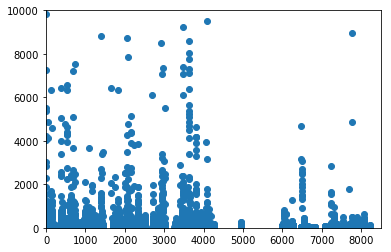

In [73]:
#quick look at spread in fuel_cost_per_mwh - how do we tell what's realistic?
plt.scatter(mcoe_by_generator.plant_id, mcoe_by_generator.fuel_cost_per_mwh)
plt.xlim([0,8500])
plt.ylim([0,10000])
plt.show()

In [19]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations.csv')

In [20]:
xlsx_writer = pd.ExcelWriter('EIA_mcoe_2011-2015.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False)
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
xlsx_writer.save()